# Bayesian test PG1244+026(14-2)

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.fftpack import fft,ifft
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from iminuit import Minuit

import emcee
from pprint import pprint
import time
from multiprocessing import Pool

import random

In [2]:
# 似然函数 p; D = -2 ln p

def twi_minus_loglikelihood(log_A,log_f_b,alpha_H,poisson):
    alpha_L = 1.0
    
    perdata142 = pd.read_csv("perlist142.csv")
    f = perdata142['f']
    per = perdata142['per']
    
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append(((f[i]**(-alpha_L))/(1+(f[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
     
    
    length = len(perdata142)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [3]:
m=Minuit(twi_minus_loglikelihood,log_A=math.log(0.005,10),log_f_b=math.log(1.7E-4,10),alpha_H=3.8,poisson=0.8,
         error_log_A=0.1,error_log_f_b=0.1,error_alpha_H=0.01,error_poisson=0.01,
         limit_log_A=(-3,-1), limit_log_f_b=(-5,-2),limit_alpha_H=(1.0,5.0),limit_poisson=(0,1),
         errordef=1)

m.migrad()

pprint(m.fval)

FCN = 844.6508555783817 
 TOTAL NCALL = 232 
 NCALLS = 232 
 
 
 EDM = 5.2722453949656146e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-2.33617,0.188546,,,-3,-1,No
1,log_f_b,-3.13473,0.413654,,,-5,-2,No
2,alpha_H,2.01029,0.526816,,,1,5,No
3,poisson,0.387201,0.0564489,,,0,1,No


844.6508555783817


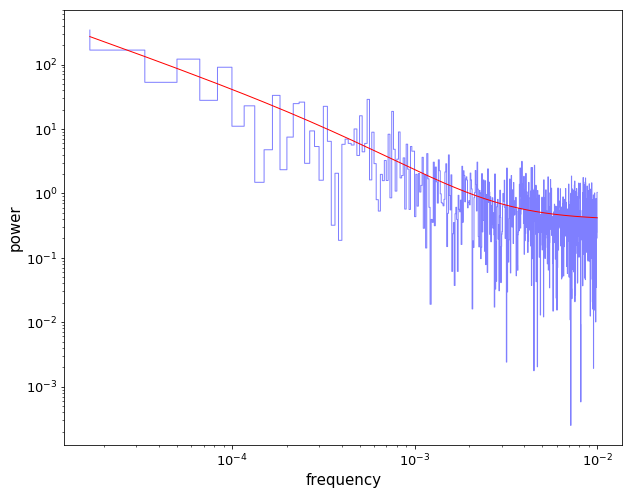

In [4]:
perdata142 = pd.read_csv("perlist142.csv")
f = perdata142['f']
per = perdata142['per']

alpha_L = 1.0
log_A,log_f_b,alpha_H,poisson = m.values[0],m.values[1],m.values[2],m.values[3]

model = []
R_obs = []
T_SSE_obs = 0
f_length = len(f)
for i in range(f_length):
    model.append(((f[i]**(-alpha_L))/(1+(f[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
    R_obs.append(2*per[i]/model[i])
    T_SSE_obs += (((per[i]-model[i])/model[i])**2)
    
plt.figure(figsize=(10,8))
plt.loglog()
plt.step(f, per, color="b", alpha=0.5, linewidth=1)
plt.plot(f, model, color="r", linewidth=1)
plt.xlabel("frequency",fontsize=15)
plt.ylabel("power",fontsize=15)
plt.tick_params(labelsize=13)
plt.show()

In [5]:
# 两个统计量
T_R_obs = max(R_obs)
print ("T_R =", T_R_obs)
print ("T_SSE =", T_SSE_obs)

T_R = 11.535967694678138
T_SSE = 545.4690845469614


In [6]:
# 5000条光变曲线

df = 0.01/f_length
N = 2*f_length


counts_list=[None for i in range(5000)]
for a in range(5000): 
    omega = []
    POW = []
    DFT = []
    fr = []
    fi = []
    f1 = []
    for j in range(1,N+1):
        omega.append(j*df)
        POW.append(((omega[-1]**(-alpha_L))/(1+(omega[-1]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
        DFT.append(complex(np.sqrt(POW[-1]*0.5),np.sqrt(POW[-1]*0.5)))
        s1=np.random.normal(loc=0.0, scale=1.0, size=None)
        s2=np.random.normal(loc=0.0, scale=1.0, size=None)
        fr.append((DFT[-1].real)*s1)
        fi.append((DFT[-1].imag)*s2)
        f1.append(complex(fr[-1],fi[-1]))
    counts = ifft(f1)
    counts_list[a] = counts
    
    
#周期图
per_list=[None for i in range(5000)]
TR_list=[]
TSSE_list=[]
n_TR = 0
n_TSSE = 0

for a in range(5000):
    dft = fft(counts_list[a])
    dft1 = dft[0:f_length]
    per_simu = (abs(dft1)**2)
    per_list[a] = per_simu
    R_simu = []
    T_SSE_simu = 0
    for i in range(f_length):
        R_simu.append(2*per_simu[i]/model[i])
        T_SSE_simu += (((per_simu[i]-model[i])/model[i])**2)
    TR_list.append(max(R_simu))
    TSSE_list.append(T_SSE_simu)
    if TR_list[-1]>T_R_obs:
        n_TR += 1
    if TSSE_list[-1]>T_SSE_obs:
        n_TSSE += 1

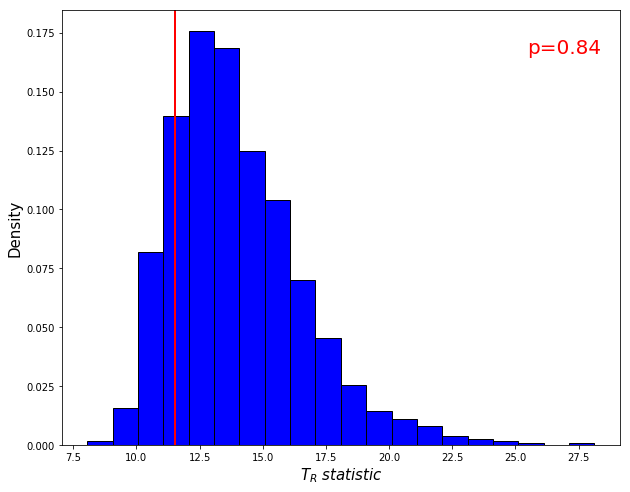

In [7]:
pc = n_TR/5000
p_TR = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TR_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_R_obs, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TR, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_R\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

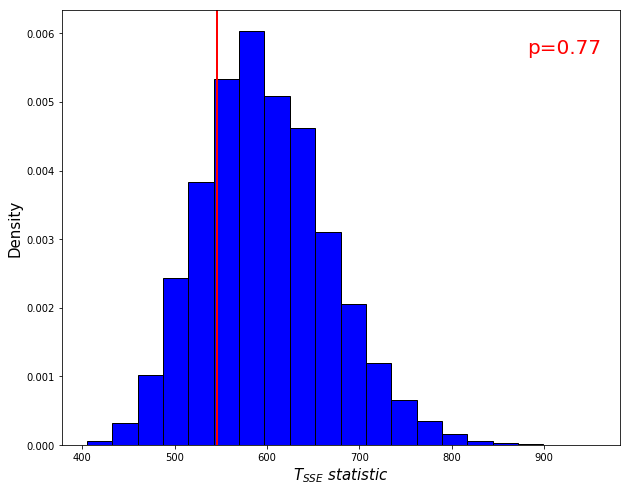

In [8]:
pc = n_TSSE/5000
p_TSSE = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TSSE_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_SSE_obs, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TSSE, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_{SSE}\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

In [9]:
# 均匀先验

def lnprior(theta):
    log_A,log_f_b,alpha_H,poisson = theta
    alpha_L = 1.0
    if -3 < log_A < -1 and -6 < log_f_b < -2 and 0.0 < alpha_H < 6.0 and 0.0 < poisson < 1.0:
        return 0.0
    return -np.inf

# 后验概率？

def lnprob(theta):
    log_A,log_f_b,alpha_H,poisson = theta
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return (lp - 0.5* twi_minus_loglikelihood(log_A,log_f_b,alpha_H,poisson))

In [10]:
# emcee

ndim, nwalkers = 4, 100
pos = [[m.values[0],m.values[1],m.values[2],m.values[3]] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)


# 显示进度并记录时间
import sys

nsteps = 500
width = 30
start = time.time()
for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
    z = int((width+1) * float(i) / nsteps)
    sys.stdout.write("\r[{0}{1}]".format('#' * z, ' ' * (width - z)))
sys.stdout.write("\n")
end = time.time()
multi_time = end - start
print("Serial took {0:.1f} seconds".format(multi_time))

[##############################]
Serial took 937.6 seconds


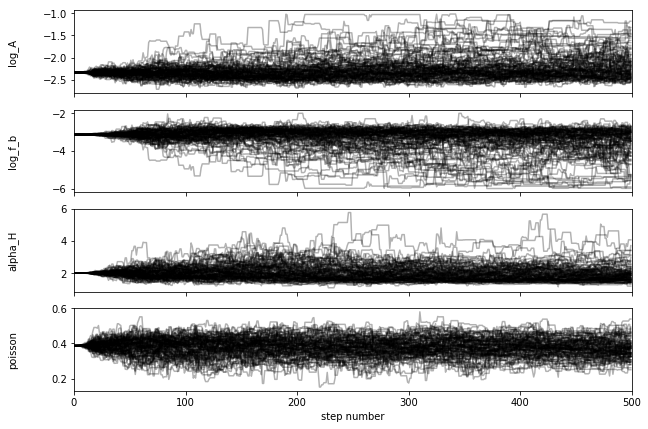

In [11]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.chain
labels = ["log_A", "log_f_b", "alpha_H","poisson"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(np.transpose(samples[:,:,i]), "k", alpha=0.3)
    ax.set_xlim(0, len(samples[1]))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [12]:
samples = sampler.chain[:, 100:, :].reshape((-1, ndim))

labels = ["log A", "log f_b", "alpha_H","poisson"]

from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}} ^{{+{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

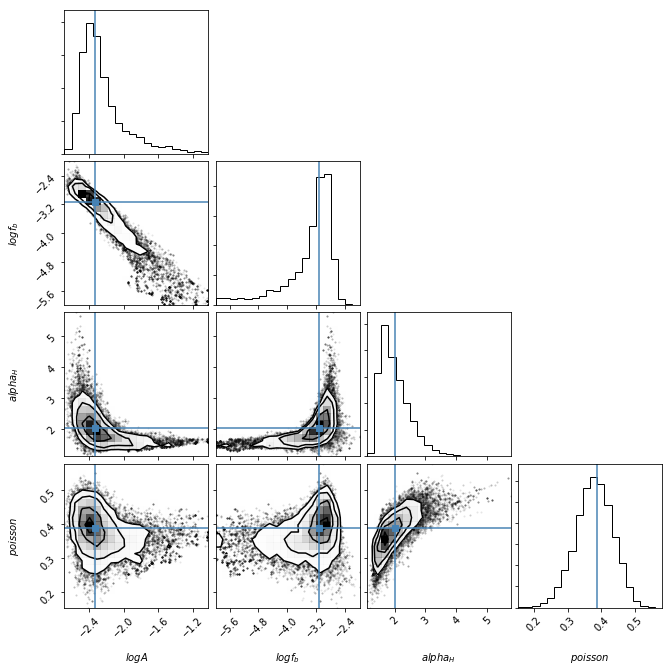

In [13]:
import corner
fig = corner.corner(samples, labels=["$log A$", "$log f_b$", "$alpha_H$", "$poisson$"],
                      truths=[m.values[0], m.values[1], m.values[2], m.values[3]])

#

#

#

#

#

In [14]:
def twi_minus_loglikelihood_nobreak(log_A,alpha,poisson):
    alpha_L = 1.0
    
    perdata142 = pd.read_csv("perlist142.csv")
    f = perdata142['f']
    per = perdata142['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append((f[i]**(-alpha))*(10**log_A)+poisson)
     
    
    length = len(perdata142)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [15]:
n=Minuit(twi_minus_loglikelihood_nobreak,log_A=-9,alpha=2.0,poisson=1.0,
         error_log_A=0.1,error_alpha=0.01,error_poisson=0.01,
         limit_log_A=(-10,-1),limit_alpha=(1.0,5.0),limit_poisson=(0,1),
         errordef=1)

n.migrad()

print(n.fval)
n.print_param()

FCN = 846.3575757935381 
 TOTAL NCALL = 162 
 NCALLS = 162 
 
 
 EDM = 1.7714694230592013e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-3.87045,0.335936,,,-10,-1,No
1,alpha,1.38159,0.106051,,,1,5,No
2,poisson,0.31585,0.044265,,,0,1,No


846.3575757935381


+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-3.87045,0.335936,,,-10,-1,No
1,alpha,1.38159,0.106051,,,1,5,No
2,poisson,0.31585,0.044265,,,0,1,No


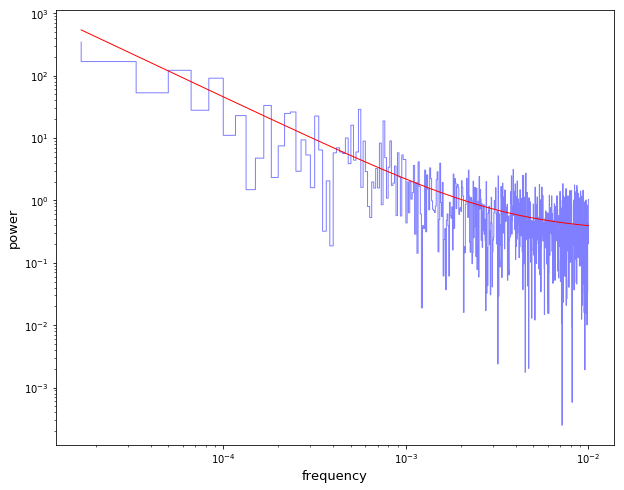

In [16]:
log_A,alpha,poisson = n.values[0],n.values[1],n.values[2]
        
model2 = []
R_obs_2 = []
T_SSE_obs_2 = 0
f_length = len(f)
for i in range(f_length):
    model2.append((f[i]**(-alpha))*(10**log_A)+poisson)
    R_obs_2.append(2*per[i]/model2[i])
    T_SSE_obs_2 += (((per[i]-model2[i])/model2[i])**2)
    
plt.figure(figsize=(10,8))
plt.loglog()
plt.step(f, per, color="b", alpha=0.5, linewidth=1)
plt.plot(f, model2, color="r", linewidth=1)
plt.xlabel("frequency",fontsize=13)
plt.ylabel("power",fontsize=13)
plt.show()

In [17]:
# 两个统计量
T_R_obs_2 = max(R_obs_2)
print ("T_R =", T_R_obs_2)
print ("T_SSE =", T_SSE_obs_2)

T_R = 12.952405483699902
T_SSE = 555.5984077672828


In [18]:
# 模拟
    
# 5000条光变曲线

df = 0.01/f_length
N = 2*f_length


counts_list_2=[None for i in range(5000)]
for a in range(5000): 
    omega = []
    POW = []
    DFT = []
    fr = []
    fi = []
    f1 = []
    for j in range(1,N+1):
        omega.append(j*df)
        POW.append(((omega[-1]**(-alpha_L))/(1+(omega[-1]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
        DFT.append(complex(np.sqrt(POW[-1]*0.5),np.sqrt(POW[-1]*0.5)))
        s1=np.random.normal(loc=0.0, scale=1.0, size=None)
        s2=np.random.normal(loc=0.0, scale=1.0, size=None)
        fr.append((DFT[-1].real)*s1)
        fi.append((DFT[-1].imag)*s2)
        f1.append(complex(fr[-1],fi[-1]))
    counts = ifft(f1)
    counts_list_2[a] = counts
    
    
#周期图
per_list_2=[None for i in range(5000)]
TR_list_2=[]
TSSE_list_2=[]
n_TR_2 = 0
n_TSSE_2 = 0

for a in range(5000):
    dft = fft(counts_list_2[a])
    dft1 = dft[0:f_length]
    per_simu = (abs(dft1)**2)
    per_list_2[a] = per_simu
    R_simu = []
    T_SSE_simu = 0
    for i in range(f_length):
        R_simu.append(2*per_simu[i]/model[i])
        T_SSE_simu += (((per_simu[i]-model[i])/model[i])**2)
    TR_list_2.append(max(R_simu))
    TSSE_list_2.append(T_SSE_simu)
    if TR_list_2[-1]>T_R_obs_2:
        n_TR_2 += 1
    if TSSE_list_2[-1]>T_SSE_obs_2:
        n_TSSE_2 += 1
    

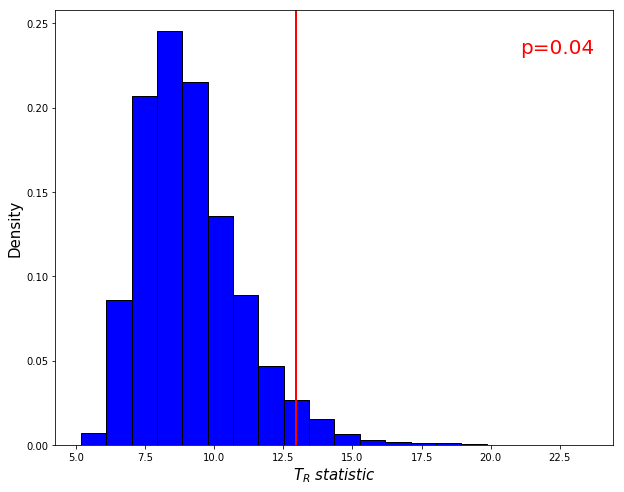

In [19]:
pc = n_TR_2/5000
p_TR_2 = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TR_list_2, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_R_obs_2, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TR_2, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_R\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

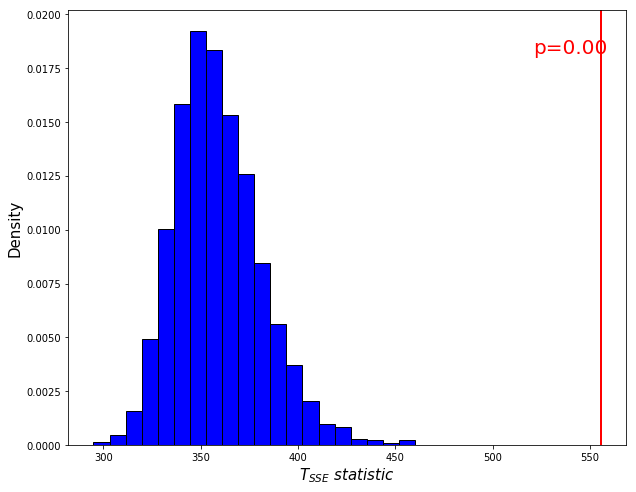

In [20]:
pc = n_TSSE_2/5000
p_TSSE_2 = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TSSE_list_2, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_SSE_obs_2, color="r", linewidth=2)
plt.text(0.9,0.9,'p=%s'%p_TSSE_2, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_{SSE}\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

In [21]:
# 对无截断幂律谱尝试emcee

# 均匀先验

def lnprior_nobreak(theta):
    log_A,alpha,poisson = theta
    if -10 < log_A < -1 and 1.0 < alpha < 5.0 and 0.0 < poisson < 1.0:
        return 0.0
    return -np.inf

# 后验概率？

def lnprob_nobreak(theta):
    log_A,alpha,poisson = theta
    lp = lnprior_nobreak(theta)
    if not np.isfinite(lp):
        return -np.inf
    return (lp - 0.5* twi_minus_loglikelihood_nobreak(log_A,alpha,poisson))

In [22]:
# emcee

ndim, nwalkers = 3, 100
pos = [[n.values[0],n.values[1],n.values[2]] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler_nobreak = emcee.EnsembleSampler(nwalkers, ndim, lnprob_nobreak)


# 显示进度并记录时间
import sys

nsteps = 500
width = 30
start = time.time()
for i, result in enumerate(sampler_nobreak.sample(pos, iterations=nsteps)):
    z = int((width+1) * float(i) / nsteps)
    sys.stdout.write("\r[{0}{1}]".format('#' * z, ' ' * (width - z)))
sys.stdout.write("\n")
end = time.time()
multi_time = end - start
print("Serial took {0:.1f} seconds".format(multi_time))

[##############################]
Serial took 670.8 seconds


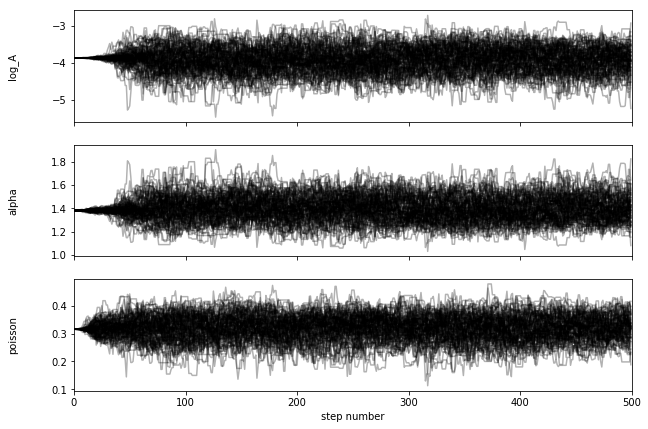

In [23]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples_nobreak = sampler_nobreak.chain
labels = ["log_A", "alpha","poisson"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(np.transpose(samples_nobreak[:,:,i]), "k", alpha=0.3)
    ax.set_xlim(0, len(samples_nobreak[1]))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [24]:
samples_nobreak = sampler_nobreak.chain[:, 100:, :].reshape((-1, ndim))
labels = ["log_A", "alpha","poisson"]

from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(samples_nobreak[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.7f}_{{-{1:.7f}}}^{{+{2:.7f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

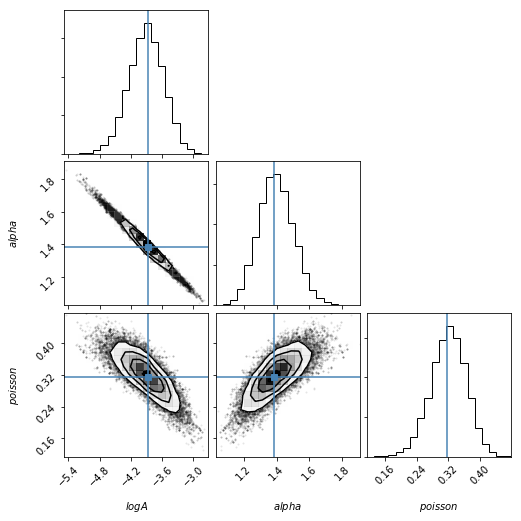

In [25]:
import corner
fig = corner.corner(samples_nobreak, labels=["$logA$", "$alpha$", "$poisson$"],
                      truths=[n.values[0], n.values[1], n.values[2]])

In [26]:
# LRT statistic
T = n.fval-m.fval
print(T)

1.7067202151564516


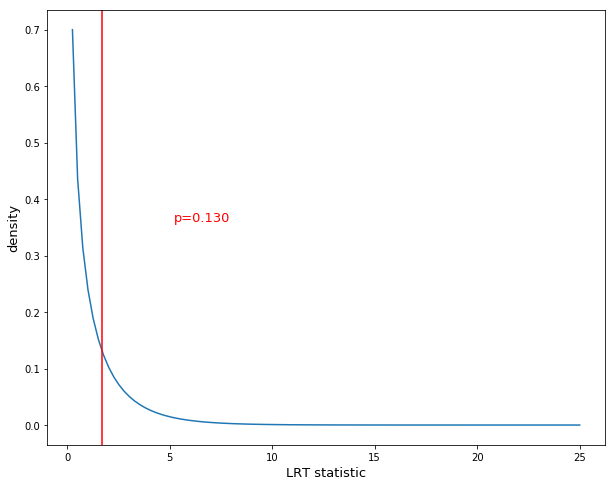

In [27]:
import scipy.stats as stats

p = stats.chi2.pdf(T,1)
p1 = ("%.3f" % p)
plt.figure(figsize=(10,8))
plt.plot(np.linspace(0,25,100),stats.chi2.pdf(np.linspace(0,25,100),df=1))
plt.axvline(T,color="r")
plt.text(0.2,1.8,'p=%s'%p1,color='red',ha='center',transform=ax.transAxes,fontsize=13)
plt.xlabel("LRT statistic",fontsize=13)
plt.ylabel("density",fontsize=13)
plt.show()